In [1]:
%run 0_Regressions_Common.ipynb

In [2]:
feature_sets = pos_feature_sets
label = positivity_label
text_label = "test positivity rate"
text_label_cap = "Positivity Rate"
label_daily = "positivity_rate"

In [3]:
file_suffix='mar9'

with open('../OtherData/CombinedDFAdjPopulationExcessMobility_%s.pkl' % (file_suffix), 'rb') as handle:
    df = pickle.load(handle)

In [4]:
with open('../OtherData/0_regions_to_skip.pkl', 'rb') as handle:
    regions_to_skip = pickle.load(handle)

with open('../OtherData/0_val_7_regions_mar9.pkl', 'rb') as handle:
    val_regions = pickle.load(handle)
     
regions = list(set([x for x in val_regions if x not in regions_to_skip]))  
print("Number of val regions: %d" % (len(regions)))

Number of val regions: 7


# Make Predictions

Run validation set feature selection with parameters representing exponentially weighted decay weekly and daily. Only one value should be >0 to represent the decay multiplier. The other value should be 0.

In [5]:
def run_exp_decay_experiments(exp_decay_weekly, exp_decay_daily):

    fs_to_region_to_dynamic_preds = dict()
    fs_to_region_to_osa_preds = dict()
    fs_to_region_to_osa_preds_train = dict()
    fs_to_region_to_osa_preds_dec = dict()

    fs_to_region_to_dynamic_mses = dict()
    fs_to_region_to_dynamic_mas = dict()
    fs_to_region_to_dynamic_mas_new = dict()
    fs_to_region_to_osa_mses = dict()
    fs_to_region_to_osa_mas = dict()
    fs_to_region_to_osa_mas_new = dict()
    fs_to_region_to_osa_mses_dec = dict()
    fs_to_region_to_osa_mas_dec = dict()
    fs_to_region_to_osa_mas_dec_new = dict()

    fs_to_region_to_dynamic_CM = dict()
    fs_to_region_to_osa_CM = dict()
    fs_to_region_to_osa_CM_train = dict()
    fs_to_region_to_osa_CM_dec = dict()
    fs_to_region_to_osa_CM_new = dict()
    fs_to_region_to_osa_CM_train_new = dict()
    fs_to_region_to_osa_CM_dec_new = dict()

    best_mse_fs_mse = 9999
    best_mse_fs_ma = 9999
    best_mse_fs_key = -1
    best_mse_fs_label = "null"

    best_ma_fs_mse = -1
    best_ma_fs_ma = -1
    best_ma_fs_key = -1
    best_ma_fs_label = "null"


    results_df = pd.DataFrame(columns=['Weekly Decay', 'Daily Decay', 'Key', 'Feature Set', 'MSE Nov',
                                       'MA Nov', 'MA (Tier) Nov', 'MSE Dec', 'MA Dec', 'MA (Tier) Dec'])

    for key in feature_sets.keys():
        features = feature_sets[key]

        fs_to_region_to_dynamic_preds[key] = dict()
        fs_to_region_to_osa_preds[key] = dict()
        fs_to_region_to_osa_preds_train[key] = dict()
        fs_to_region_to_osa_preds_dec[key] = dict()

        fs_to_region_to_dynamic_mses[key] = dict()
        fs_to_region_to_dynamic_mas[key] = dict()
        fs_to_region_to_dynamic_mas_new[key] = dict()
        fs_to_region_to_osa_mses[key] = dict()
        fs_to_region_to_osa_mas[key] = dict()
        fs_to_region_to_osa_mas_new[key] = dict()
        fs_to_region_to_osa_mses_dec[key] = dict()
        fs_to_region_to_osa_mas_dec[key] = dict()
        fs_to_region_to_osa_mas_dec_new[key] = dict()

        fs_to_region_to_dynamic_CM[key] = dict()
        fs_to_region_to_osa_CM[key] = dict()
        fs_to_region_to_osa_CM_train[key] = dict()
        fs_to_region_to_osa_CM_dec[key] = dict()
        fs_to_region_to_osa_CM_new[key] = dict()
        fs_to_region_to_osa_CM_train_new[key] = dict()
        fs_to_region_to_osa_CM_dec_new[key] = dict()

        for region in regions:
            region_start = time.time()
            od_df=df.where(df["Region"]==region).dropna()
            train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
            test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= '2020-12-07').dropna()
            train_dec = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-11-23').dropna()
            dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2021-01-07').dropna()

            train_new = train.sort_index().dropna()
            train_dec_new = train_dec.sort_index().dropna()
            test_new = test.sort_index().dropna()
            dec_new = dec.sort_index().dropna()
            features_min_max = preprocessing.MinMaxScaler()
            X_train = features_min_max.fit_transform(train_new[features])
            y_train = train_new[label]
            y_train_eval = train_new[label]
            X_test = features_min_max.transform(test_new[features])
            y_test = test_new[label]
            y_test_eval = test_new[label]
            
            X_train_dec = features_min_max.fit_transform(train_dec_new[features])
            y_train_dec = train_dec_new[label]
            y_train_dec_eval = train_dec_new[label]
            X_dec = features_min_max.transform(dec_new[features])
            y_dec = dec_new[label]
            y_dec_eval = dec_new[label]

            dynamic_preds = make_dynamic_preds(X_train, y_train, X_test, y_test,
                                               exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds = make_osa_preds(X_train, y_train, X_test, y_test,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)
            osa_preds_dec = make_osa_preds(X_train_dec, y_train_dec, X_dec, y_dec,
                                       exp_decay_weekly=exp_decay_weekly, exp_decay_daily=exp_decay_daily)


            fs_to_region_to_dynamic_preds[key][region] = dynamic_preds
            fs_to_region_to_osa_preds[key][region] = osa_preds
            fs_to_region_to_osa_preds_dec[key][region] = osa_preds_dec

            dynamic_mse = mean_squared_error(dynamic_preds[:-7], y_test_eval[:-7])
            dynamic_ma = magnitude_accuracy_pr(dynamic_preds, y_test_eval)
            dynamic_ma_new = magnitude_accuracy_prt(dynamic_preds, y_test_eval)
            osa_mse = mean_squared_error(osa_preds[:-7], y_test_eval[:-7]) 
            osa_ma = magnitude_accuracy_pr(osa_preds, y_test_eval) 
            osa_ma_new = magnitude_accuracy_prt(osa_preds, y_test_eval) 
            osa_mse_dec = mean_squared_error(osa_preds_dec[:-7], y_dec_eval[:-7]) 
            osa_ma_dec = magnitude_accuracy_pr(osa_preds_dec, y_dec_eval) 
            osa_ma_dec_new = magnitude_accuracy_prt(osa_preds_dec, y_dec_eval) 

            fs_to_region_to_dynamic_mses[key][region] = dynamic_mse
            fs_to_region_to_dynamic_mas[key][region] = dynamic_ma
            fs_to_region_to_osa_mses[key][region] = osa_mse
            fs_to_region_to_osa_mas[key][region] = osa_ma
            fs_to_region_to_osa_mas_new[key][region] = osa_ma_new
            fs_to_region_to_osa_mses_dec[key][region] = osa_mse_dec
            fs_to_region_to_osa_mas_dec[key][region] = osa_ma_dec
            fs_to_region_to_osa_mas_dec_new[key][region] = osa_ma_dec_new

            fs_to_region_to_dynamic_CM[key][region] = confusion_matrix_pr(dynamic_preds, y_test)
            fs_to_region_to_osa_CM[key][region] = confusion_matrix_pr(osa_preds, y_test)
            fs_to_region_to_osa_CM_new[key][region] = confusion_matrix_prt(osa_preds, y_test)
            fs_to_region_to_osa_CM_dec[key][region] = confusion_matrix_pr(osa_preds_dec, y_dec_eval)
            fs_to_region_to_osa_CM_dec_new[key][region] = confusion_matrix_prt(osa_preds_dec, y_dec_eval)

            region_end = time.time()
        this_fs_dynamic_average_mse = np.mean(list(fs_to_region_to_dynamic_mses[key].values()))
        this_fs_dynamic_average_ma = np.mean(list(fs_to_region_to_dynamic_mas[key].values()))
        this_fs_osa_average_mse = np.mean(list(fs_to_region_to_osa_mses[key].values()))
        this_fs_osa_average_ma = np.mean(list(fs_to_region_to_osa_mas[key].values()))
        this_fs_osa_average_ma_new = np.mean(list(fs_to_region_to_osa_mas_new[key].values()))
        this_fs_osa_average_mse_dec = np.mean(list(fs_to_region_to_osa_mses_dec[key].values()))
        this_fs_osa_average_ma_dec = np.mean(list(fs_to_region_to_osa_mas_dec[key].values()))
        this_fs_osa_average_ma_dec_new = np.mean(list(fs_to_region_to_osa_mas_dec_new[key].values()))

        if this_fs_dynamic_average_mse < this_fs_osa_average_mse:
            best_mse_model_mse = this_fs_dynamic_average_mse
            best_mse_model_ma = this_fs_dynamic_average_ma
            best_mse_model_ma_new = -1
            best_mse_model_label = "dynamic"
            best_mse_model_mse_dec = -1
            best_mse_model_ma_dec = -1
            best_mse_model_ma_dec_new = -1
        else:
            best_mse_model_mse = this_fs_osa_average_mse
            best_mse_model_ma = this_fs_osa_average_ma
            best_mse_model_ma_new = this_fs_osa_average_ma_new
            best_mse_model_label = "osa"
            best_mse_model_mse_dec = this_fs_osa_average_mse_dec
            best_mse_model_ma_dec = this_fs_osa_average_ma_dec
            best_mse_model_ma_dec_new = this_fs_osa_average_ma_dec_new

        if best_mse_model_mse < best_mse_fs_mse:
            best_mse_fs_mse = best_mse_model_mse
            best_mse_fs_ma = best_mse_model_ma
            best_mse_fs_key = key
            best_mse_fs_label = best_mse_model_label
    
        results_df = results_df.append({'Weekly Decay': exp_decay_weekly,
                                        'Daily Decay': exp_decay_daily,
                                        'Key': key,
                                        'Feature Set': feature_sets[key],
                                        'MSE Nov': best_mse_model_mse,
                                        'MA Nov': best_mse_model_ma,
                                        'MA (Tier) Nov': best_mse_model_ma_new,
                                        'MSE Dec': best_mse_model_mse_dec,
                                        'MA Dec': best_mse_model_ma_dec,
                                       'MA (Tier) Dec': best_mse_model_ma_dec_new}, ignore_index=True)
    
    return results_df, fs_to_region_to_dynamic_preds, fs_to_region_to_osa_preds, fs_to_region_to_osa_preds_dec

In [6]:
results_df_list = list()
dynamic_preds_list = list()
osa_preds_list = list()
dec_osa_preds_list = list()

decays = [0.5**0.5]

for weekly_decay in decays:
    this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(weekly_decay, 0)
    results_df_list.append(this_r_df)
    dynamic_preds_list.append(this_dynamic_preds)
    osa_preds_list.append(this_osa_preds)
    dec_osa_preds_list.append(this_dec_preds)
    
for daily_decay in decays:
    this_r_df, this_dynamic_preds, this_osa_preds, this_dec_preds = run_exp_decay_experiments(0, daily_decay)
    results_df_list.append(this_r_df)
    dynamic_preds_list.append(this_dynamic_preds)
    osa_preds_list.append(this_osa_preds)
    dec_osa_preds_list.append(this_dec_preds)

In [7]:
all_results = pd.concat(results_df_list)

In [8]:
all_results.sort_values(by=['MSE Nov'], ascending=True).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec
10,0,0.707107,11,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000097,0.766667,0.719048,0.000392,0.626728,0.534562
11,0,0.707107,12,[Positivity_Rate_7_1dayago],0.000098,0.785714,0.723810,0.000223,0.640553,0.589862
28,0.707107,0,29,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000099,0.742857,0.709524,0.000283,0.695853,0.617512
28,0,0.707107,29,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000106,0.728571,0.661905,0.000931,0.626728,0.589862
11,0.707107,0,12,[Positivity_Rate_7_1dayago],0.000115,0.690476,0.680952,0.000189,0.626728,0.516129
25,0,0.707107,26,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000115,0.690476,0.657143,0.001203,0.626728,0.617512
10,0.707107,0,11,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000118,0.642857,0.628571,0.000154,0.668203,0.589862
7,0,0.707107,8,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000119,0.752381,0.700000,0.000314,0.589862,0.539171
15,0,0.707107,16,"[Positivity_Rate_7_1dayago, Diff Internal_Move...",0.000121,0.771429,0.719048,0.000377,0.557604,0.640553
16,0,0.707107,17,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000122,0.723810,0.695238,0.000284,0.645161,0.580645


In [9]:
results_to_consider = all_results.where(all_results["MSE Dec"] >=0).dropna()
results_to_consider["Eval MSE"] = (results_to_consider["MSE Nov"] * 30 + results_to_consider["MSE Dec"] * 31) / (61)
results_to_consider["Eval MA"] = (results_to_consider["MA Nov"] * 30 + results_to_consider["MA Dec"] * 31) / (61)
results_to_consider["Eval MA (Tier)"] = (results_to_consider["MA (Tier) Nov"] * 30 + results_to_consider["MA (Tier) Dec"] * 31) / (61)

In [10]:
np.sqrt(0.000298542)

0.017278367978486857

In [11]:
results_to_consider.sort_values(by=['Eval MSE'], ascending=True).head(15)

,Weekly Decay,Daily Decay,Key,Feature Set,MSE Nov,MA Nov,MA (Tier) Nov,MSE Dec,MA Dec,MA (Tier) Dec,Eval MSE,Eval MA,Eval MA (Tier)
10,0.707107,0,11,"[Positivity_Rate_7_1dayago, Excess Pressure_7_...",0.000118,0.642857,0.628571,0.000154,0.668203,0.589862,0.000137,0.655738,0.608899
16,0.707107,0,17,"[Positivity_Rate_7_1dayago, Excess Internal_Mo...",0.000134,0.638095,0.628571,0.000143,0.709677,0.626728,0.000139,0.674473,0.627635
31,0.707107,0,32,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000144,0.614286,0.633333,0.000142,0.691244,0.626728,0.000143,0.653396,0.629977
7,0.707107,0,8,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000146,0.628571,0.590476,0.000145,0.663594,0.585253,0.000145,0.646370,0.587822
2,0.707107,0,3,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000178,0.571429,0.547619,0.000122,0.718894,0.672811,0.000149,0.646370,0.611241
11,0.707107,0,12,[Positivity_Rate_7_1dayago],0.000115,0.690476,0.680952,0.000189,0.626728,0.516129,0.000152,0.658080,0.597190
11,0,0.707107,12,[Positivity_Rate_7_1dayago],0.000098,0.785714,0.723810,0.000223,0.640553,0.589862,0.000161,0.711944,0.655738
43,0.707107,0,44,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000186,0.580952,0.566667,0.000151,0.677419,0.640553,0.000168,0.629977,0.604215
41,0.707107,0,42,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000126,0.628571,0.633333,0.000211,0.709677,0.645161,0.000169,0.669789,0.639344
36,0.707107,0,37,"[Positivity_Rate_7_1dayago, Positivity_Rate_7_...",0.000160,0.600000,0.571429,0.000187,0.686636,0.599078,0.000174,0.644028,0.585480


In [12]:
toplot_x = np.sqrt(results_to_consider["MSE Nov"])
toplot_y = np.sqrt(np.array(results_to_consider["MSE Dec"], dtype=np.float64))

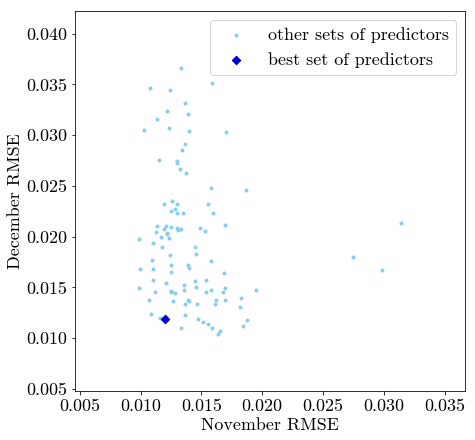

In [20]:
change_font_size(18)
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(toplot_x, toplot_y, label="other sets of predictors", marker='.', color='skyblue')
plt.scatter(np.sqrt(results_to_consider["MSE Nov"].loc[31].iloc[0]), np.sqrt(results_to_consider["MSE Dec"].loc[31].iloc[0]),
            color='mediumblue', label='best set of predictors', marker='D')
#plt.ylim((0, 800))
#plt.title("Test Positivity Rate")
plt.xlabel("November RMSE")
plt.ylabel("December RMSE")
plt.legend()
plt.show()

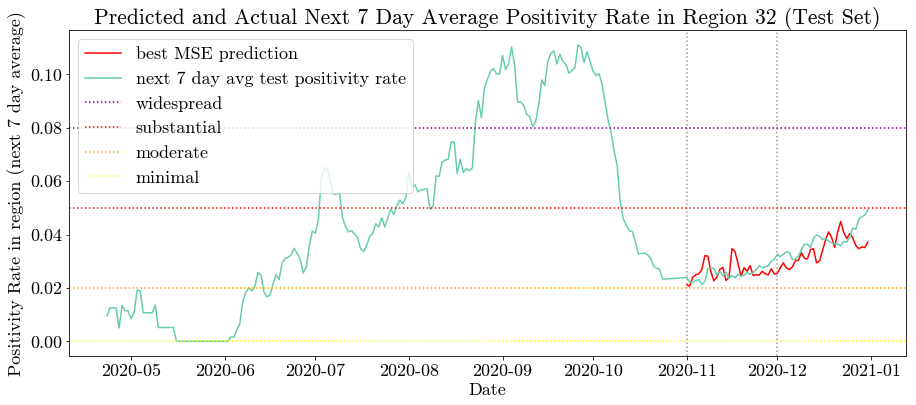

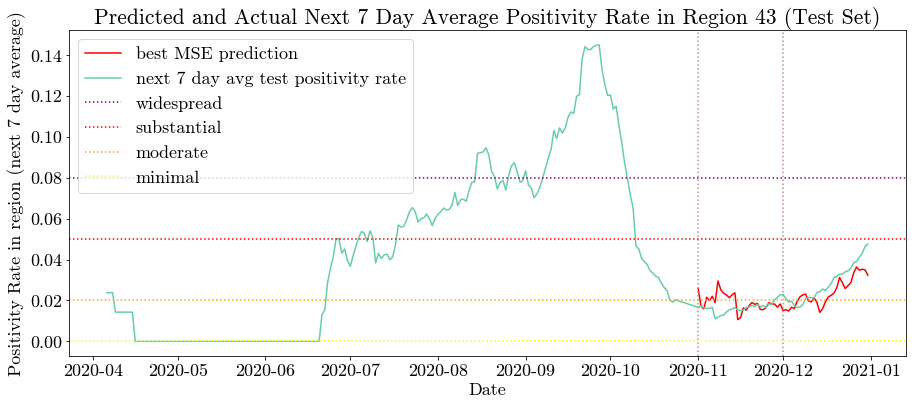

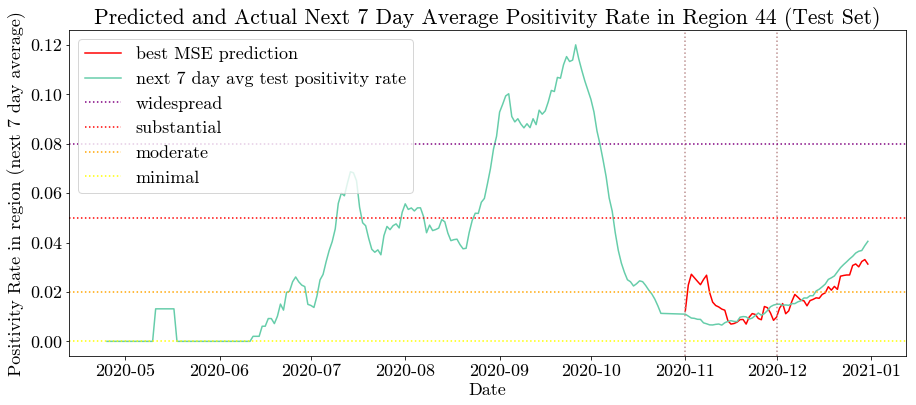

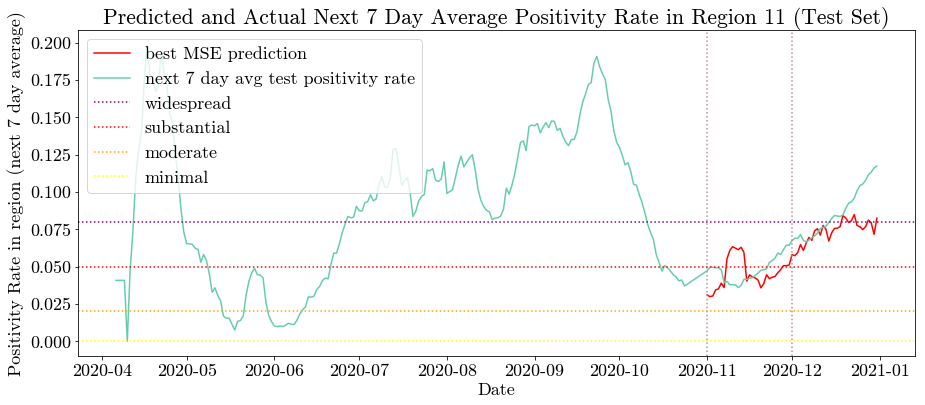

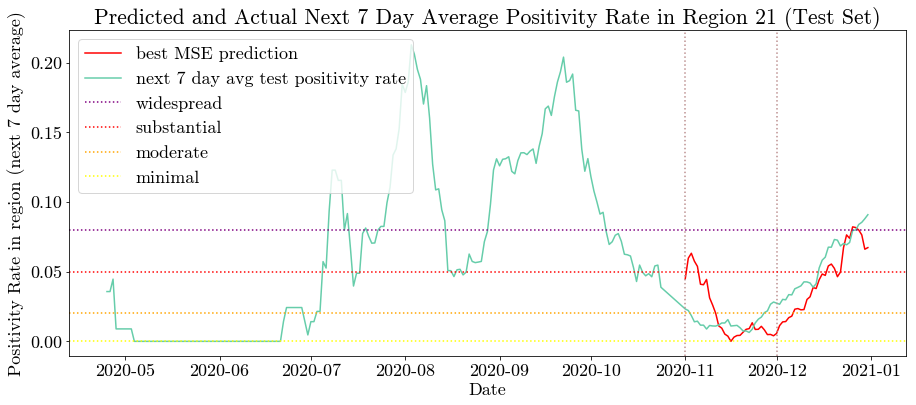

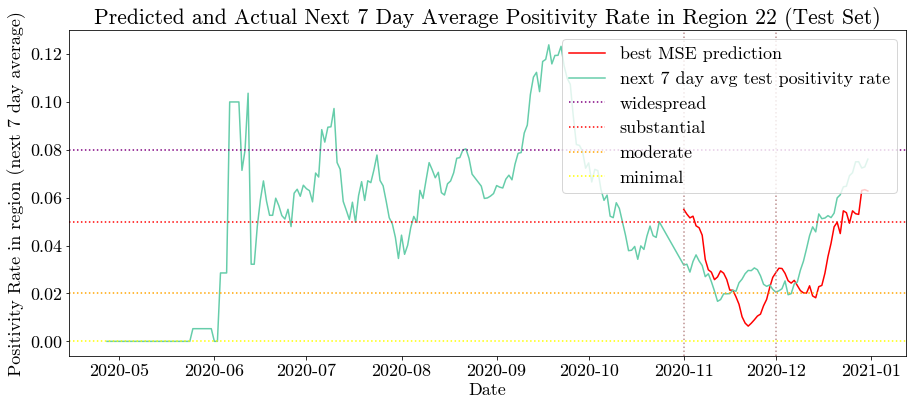

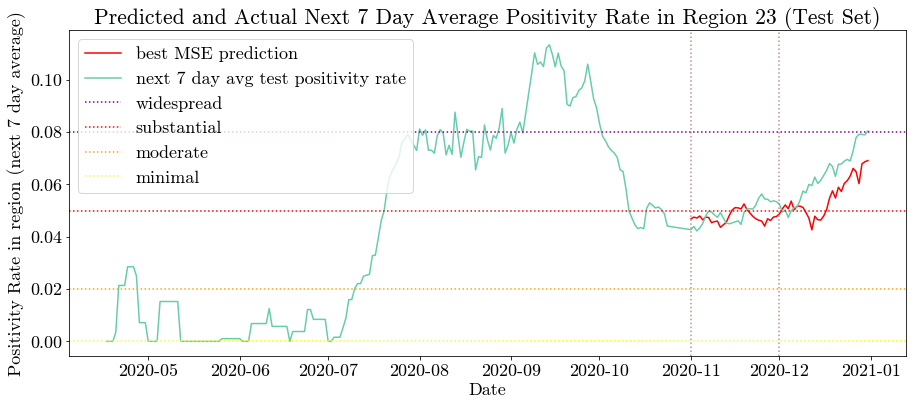

In [18]:
for region in regions:
     
    od_df=df.where(df["Region"]==region).dropna()
    train = od_df.where(od_df["Date"] >= train_begin).where(od_df["Date"] <= '2020-10-24').dropna()
    test = od_df.where(od_df["Date"] >= '2020-11-01').where(od_df["Date"] <= test_end_nov).dropna()
    dec = od_df.where(od_df["Date"] >= '2020-12-01').where(od_df["Date"] <= '2020-12-31').dropna()

    train_new = train.sort_index().dropna()
    test_new = test.sort_index().dropna()
    dec_new = dec.sort_index().dropna()
    y_train = train_new[label]
    y_test = test_new[label]
    y_dec = dec_new[label] 
    
    train_copy = train.copy()
    test_copy = test.copy()
    dec_copy = dec.copy()

    train_copy["actual"] = y_train
    train_copy["pred"] = y_train
    test_copy["actual"] = y_test
    test_copy["best_mse"] = osa_preds_list[0][32][region][:-7]
    dec_copy["actual"] = y_dec
    dec_copy["best_mse"] = dec_osa_preds_list[0][32][region][:-7]
        
    pred_all = pd.concat([train_copy, test_copy, dec_copy])

    # plot the final result on a sample dataset    
    toplot = pred_all
    toplot['Date'] = pd.to_datetime(toplot['Date'])
    fig, ax = plt.subplots(figsize=(15,6))
    plt.plot(toplot['Date'], toplot['best_mse'], color='red', label='best MSE prediction')
    plt.plot(toplot['Date'], toplot['actual'], color='mediumaquamarine', label='next 7 day avg %s' % (text_label))
    plt.axvline(x='2020-12-01', color='rosybrown', linestyle='dotted')
    plt.axvline(x='2020-11-01', color='rosybrown', linestyle='dotted')
    plt.axhline(y=widespread_positivity, color='purple', linestyle='dotted', label='widespread')
    plt.axhline(y=substantial_positivity, color='red', linestyle='dotted', label='substantial')
    plt.axhline(y=moderate_positivity, color='orange', linestyle='dotted', label='moderate')
    plt.axhline(y=minimal_positivity, color='yellow', linestyle='dotted', label='minimal')
    plt.legend(loc=0)
    plt.xlabel("Date")
    plt.ylabel("%s in region (next 7 day average)" % (text_label_cap))
    plt.title("Predicted and Actual Next 7 Day Average %s in Region %d (Test Set)" % (text_label_cap, region))
    plt.show()

# Dump Validation Set predictions to file

In [15]:
# dump experiments on exp decay results df and predictions
dump_to_pickle(all_results, '../OtherData/PosRateExpDecayValSetResults2_%s.pkl' % (file_suffix))
dump_to_pickle(dynamic_preds_list, '../OtherData/PosRateExpDecayValSetDynamicPred2s_%s.pkl' % (file_suffix))
dump_to_pickle(osa_preds_list, '../OtherData/PosRateExpDecayValSetOSAPred2s_%s.pkl' % (file_suffix))
dump_to_pickle(dec_osa_preds_list, '../OtherData/PosRateExpDecayValSetOSAPredsDec2_%s.pkl' % (file_suffix))

Saved file
Saved file
Saved file
Saved file


In [16]:
results_to_consider.to_csv("../OtherData/PosRateExpResults.csv")